C:\Users\riakh\AppData\Local\Temp\ipykernel_24120\3209002967.py:38: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(statevector):


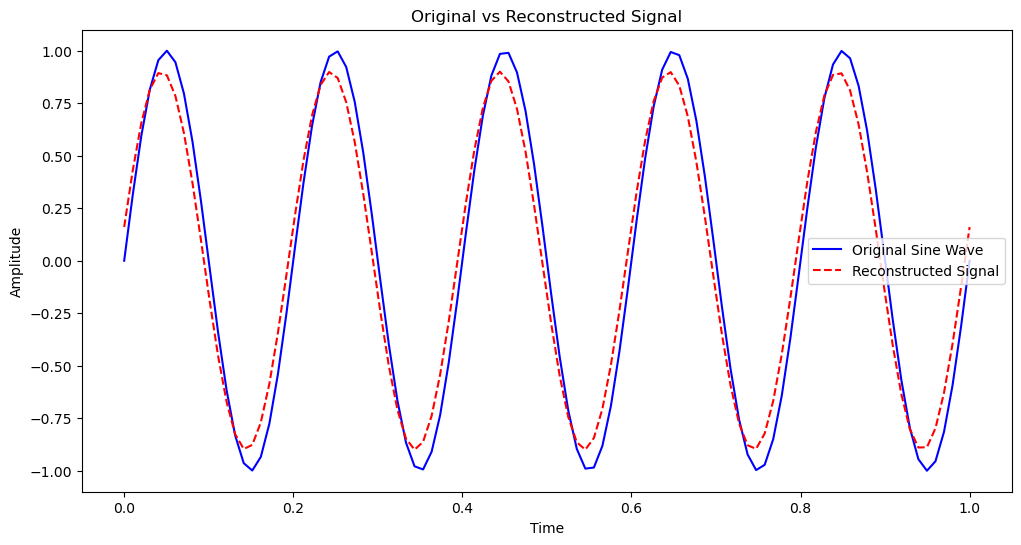

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute


NUM_QUBITS = 8
FREQUENCY = 5


def generate_spike_train(num_samples=100, frequency=FREQUENCY):
    t = np.linspace(0, 1, num_samples)
    signal = np.sin(2 * np.pi * frequency * t)
    poisson_rate = (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) * 5 + 1
    spikes = np.random.poisson(poisson_rate)
    return t, spikes, signal


def bin_spikes(t, spikes, Q=NUM_QUBITS):
    max_t = np.max(t)
    bin_indices = np.floor(Q * t / (max_t + 1e-6)).astype(int)
    bin_indices = np.clip(bin_indices, 0, Q - 1)

    a = np.zeros(Q)
    tau = np.zeros(Q)

    for i in range(Q):
        bin_times = t[bin_indices == i]
        bin_amps = spikes[bin_indices == i]
        if len(bin_amps) > 0:
            a[i] = np.mean(bin_amps)
            tau[i] = np.mean(bin_times)

    
    a = np.pi * a / (np.max(a) + 1e-6)
    tau = 2 * np.pi * tau / (np.max(tau) + 1e-6)
    return a, tau


def quantum_encode(amplitudes, phases):
    qc = QuantumCircuit(NUM_QUBITS)
    qc.h(range(NUM_QUBITS))  # Hadamard initialization
    for j in range(NUM_QUBITS):
        amp = amplitudes[j] if j < len(amplitudes) else 0
        phi = phases[j] if j < len(phases) else 0
        qc.u(amp, phi, -phi, j)  # U(a, τ, -τ)
    return qc


def apply_vqc(qc, theta):
    for j in range(NUM_QUBITS):
        qc.ry(theta[j], j)
        qc.rz(theta[j + NUM_QUBITS], j)
    for j in range(NUM_QUBITS - 1):
        qc.cx(j, j + 1)
    return qc


def get_statevector(qc):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    return result.get_statevector(qc)


def reconstruct_signal_from_state(statevector, t, frequency=FREQUENCY):
    reconstructed = np.zeros_like(t)
    for amp in statevector:
        reconstructed += abs(amp) * np.sin(2 * np.pi * frequency * t + np.angle(amp))
    return reconstructed


def main_signal_reconstruction():
    t, spikes, original_signal = generate_spike_train()
    a, tau = bin_spikes(t, spikes)
    qc = quantum_encode(a, tau)

    theta = np.random.uniform(0, 2 * np.pi, 2 * NUM_QUBITS)
    qc = apply_vqc_layer(qc, theta)

    statevector = get_statevector(qc)
    reconstructed = reconstruct_signal_from_state(statevector, t)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t, original_signal, label="Original Sine Wave")
    plt.plot(t, reconstructed, '--', label="Reconstructed from Quantum State")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Signal Reconstruction via Spike-based Quantum Encoding + VQC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main_signal_reconstruction()


In [66]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


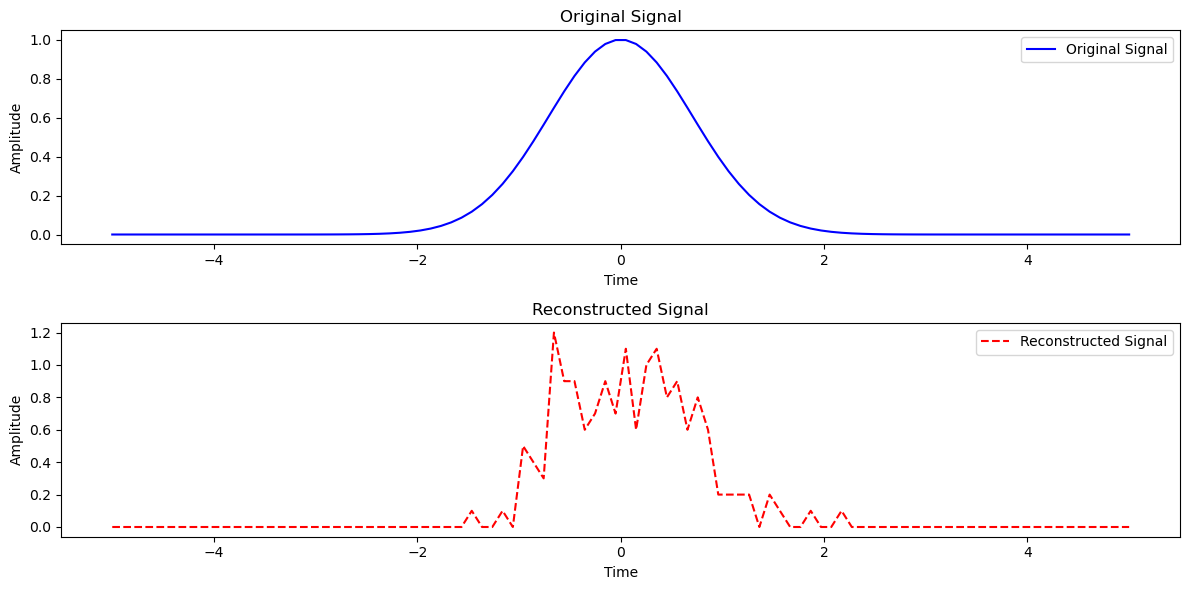

In [ ]:

NUM_QUBITS = 8


def generate_gaussian_spikes(num_samples=100):
    t = np.linspace(-5, 5, num_samples)
    signal = np.exp(-t**2)  # Gaussian
    normalized = (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) * 5 + 1
    spikes = np.random.poisson(normalized)
    return t, spikes, signal



def bin_spikes(t, spikes, Q=NUM_QUBITS):
    max_t = np.max(t)
    bin_indices = np.floor(Q * (t - np.min(t)) / (max_t - np.min(t) + 1e-6)).astype(int)
    bin_indices = np.clip(bin_indices, 0, Q - 1)

    a = np.zeros(Q)
    tau = np.zeros(Q)
    for i in range(Q):
        bin_times = t[bin_indices == i]
        bin_spike_vals = spikes[bin_indices == i]
        if len(bin_spike_vals) > 0:
            a[i] = np.mean(bin_spike_vals)
            tau[i] = np.mean(bin_times)

    a = np.pi * a / (np.max(a) + 1e-6)
    tau = 2 * np.pi * (tau - np.min(tau)) / (np.max(tau) - np.min(tau) + 1e-6)
    return a, tau


def quantum_encode(a, tau):
    qc = QuantumCircuit(NUM_QUBITS)
    qc.h(range(NUM_QUBITS))  # Hadamard to all
    for j in range(NUM_QUBITS):
        amp = a[j] if j < len(a) else 0
        phi = tau[j] if j < len(tau) else 0
        qc.u(amp, phi, -phi, j)
    return qc


def apply_vqc_layer(qc, theta):
    for j in range(NUM_QUBITS):
        qc.ry(theta[j], j)
        qc.rz(theta[j + NUM_QUBITS], j)
    for j in range(NUM_QUBITS - 1):
        qc.cx(j, j + 1)
    return qc


def get_statevector(qc):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    return result.get_statevector(qc)


def reconstruct_signal(statevector, t):
    reconstructed = np.zeros_like(t)
    for amp in statevector:
        reconstructed += abs(amp) * np.exp(-t**2) * np.cos(np.angle(amp))
    return reconstructed


def plot_results(t, original_signal, reconstructed_signal):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, original_signal, 'b-', label='Original Gaussian Signal')
    plt.title("Original Signal")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(t, reconstructed_signal, 'r--', label='Reconstructed Signal (Quantum)')
    plt.title("Reconstructed Signal")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    t, spikes, original_signal = generate_gaussian_spikes()
    a, tau = bin_spikes(t, spikes)
    qc = quantum_encode(a, tau)
    theta = np.random.uniform(0, 2 * np.pi, 2 * NUM_QUBITS)
    qc = apply_vqc_layer(qc, theta)
    statevector = get_statevector(qc)
    reconstructed_signal = reconstruct_signal(statevector, t)
    plot_results(t, original_signal, reconstructed_signal)

if __name__ == "__main__":
    main()


C:\Users\riakh\AppData\Local\Temp\ipykernel_20692\3280496629.py:43: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  compiled_circuit = qc.bind_parameters(param_dict)


Epoch 1/2000
100/100 [==============================] - 3s 2ms/step - loss: 0.2287
Epoch 2/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1824
Epoch 3/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1733
Epoch 4/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1759
Epoch 5/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1763
Epoch 6/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1701
Epoch 7/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1767
Epoch 8/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1655
Epoch 9/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1713
Epoch 10/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1664
Epoch 11/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1648
Epoch 12/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.1542
E

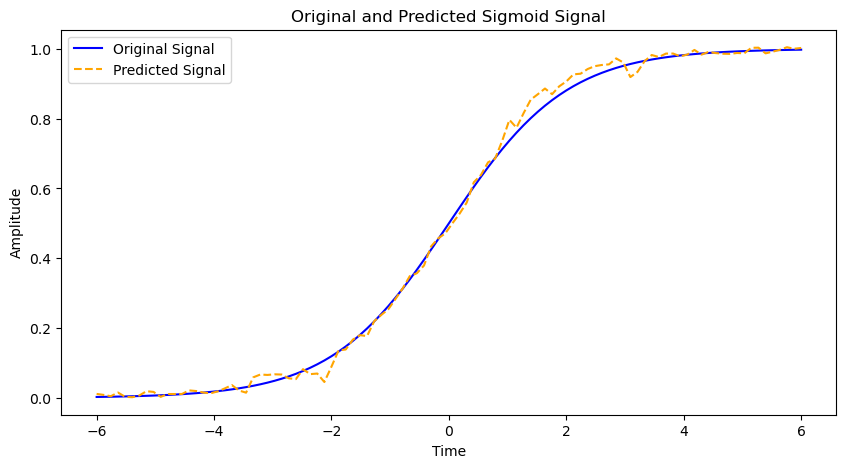

C:\Users\riakh\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)
C:\Users\riakh\AppData\Local\Temp\ipykernel_20692\3280496629.py:43: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  compiled_circuit = qc.bind_parameters(param_dict)


Epoch 1/2000
100/100 [==============================] - 3s 2ms/step - loss: 0.4989
Epoch 2/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4963
Epoch 3/2000
100/100 [==============================] - 0s 3ms/step - loss: 0.5000
Epoch 4/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4987
Epoch 5/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4968
Epoch 6/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4977
Epoch 7/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4950
Epoch 8/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4968
Epoch 9/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4879
Epoch 10/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4869
Epoch 11/2000
100/100 [==============================] - 0s 3ms/step - loss: 0.4730
Epoch 12/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.4787
E

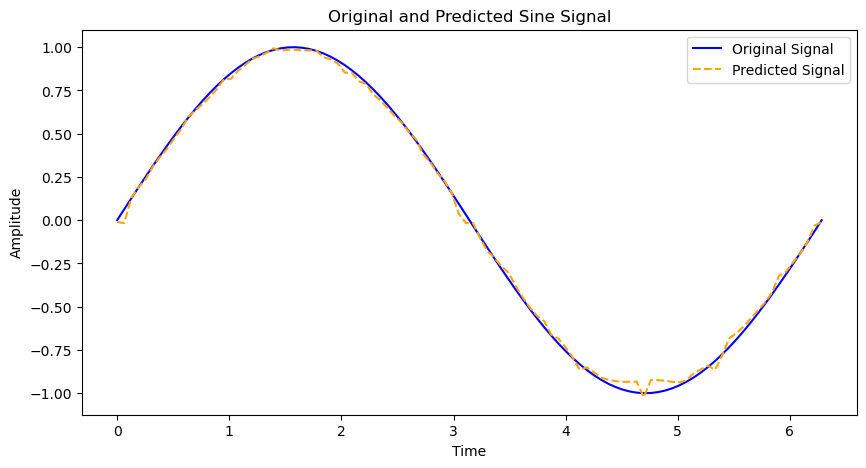

C:\Users\riakh\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)
C:\Users\riakh\AppData\Local\Temp\ipykernel_20692\3280496629.py:43: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  compiled_circuit = qc.bind_parameters(param_dict)


Epoch 1/2000
100/100 [==============================] - 3s 2ms/step - loss: 0.5087
Epoch 2/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5080
Epoch 3/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5064
Epoch 4/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5105
Epoch 5/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5075
Epoch 6/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5071
Epoch 7/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5065
Epoch 8/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5086
Epoch 9/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5069
Epoch 10/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5059
Epoch 11/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5069
Epoch 12/2000
100/100 [==============================] - 0s 2ms/step - loss: 0.5050
E

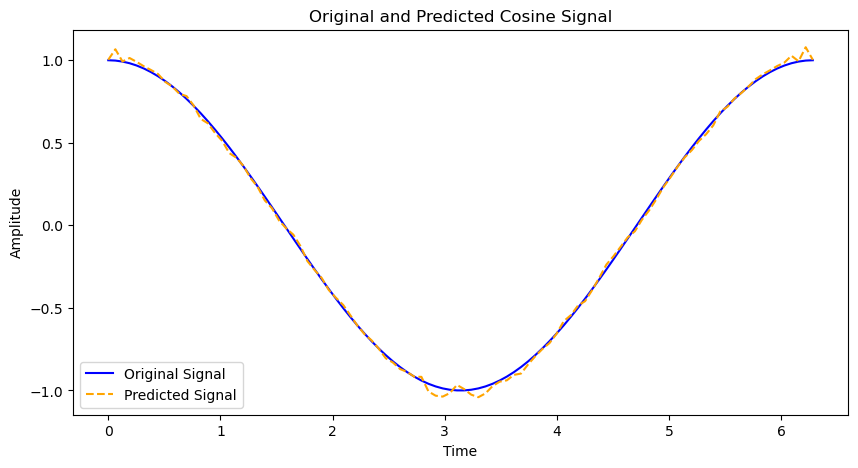

C:\Users\riakh\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [ ]:

NUM_QUBITS = 5
SHOTS = 1024

def generate_spikes_from_signal(signal):
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) * 5 + 1
    spikes = np.random.poisson(normalized_signal)
    return spikes

def get_signal_and_time(num_samples, func_type="sigmoid"):
    t = np.linspace(0, 2 * np.pi, num_samples)
    if func_type == "sigmoid":
        signal = 1 / (1 + np.exp(-np.linspace(-6, 6, num_samples)))
    elif func_type == "sine":
        signal = np.sin(t)
    elif func_type == "cosine":
        signal = np.cos(t)
    else:
        raise ValueError("Unsupported signal type")
    return signal, t

def bin_spikes(spikes, times, Q):
    max_t = np.max(times)
    bin_indices = np.floor(Q * times / (max_t + 1e-6)).astype(int)
    bin_indices = np.clip(bin_indices, 0, Q - 1)

    a = np.zeros(Q)
    tau = np.zeros(Q)

    for i in range(Q):
        bin_times = times[bin_indices == i]
        bin_amps = spikes[bin_indices == i]
        if len(bin_amps) > 0:
            a[i] = np.mean(bin_amps)
            tau[i] = np.mean(bin_times)
    a = np.pi * a / (np.max(a) + 1e-6)
    tau = 2 * np.pi * tau / (np.max(tau) + 1e-6)
    return a, tau

def quantum_encode(amplitudes, times):
    qc = QuantumCircuit(NUM_QUBITS)
    for j in range(NUM_QUBITS):
        amp = amplitudes[j] if j < len(amplitudes) else 0
        phi = times[j] if j < len(times) else 0
        qc.u(amp, phi, -phi, j)
    return qc

def apply_vqc(qc, theta):
    for j in range(NUM_QUBITS):
        qc.ry(theta[j], j)
        qc.rz(theta[j + NUM_QUBITS], j)
    for j in range(NUM_QUBITS - 1):
        qc.cx(j, j + 1)
    return qc

def encode_sample(spikes, t, theta=None):
    Q = NUM_QUBITS
    a, tau = bin_spikes(spikes, t, Q)
    qc = quantum_encode(a, tau)
    if theta is None:
        theta = np.random.uniform(0, 2 * np.pi, 2 * Q)
    qc = apply_vqc(qc, theta)
    qc.measure_all()
    backend = Aer.get_backend("aer_simulator")
    result = execute(qc, backend, shots=SHOTS).result()
    counts = result.get_counts()
    vec = np.array([counts.get(bin(i)[2:].zfill(Q), 0) for i in range(2 ** Q)])
    return vec / np.sum(vec)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(100),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def run_pipeline(func_type):
    num_samples = 100
    signal, t = get_signal_and_time(num_samples, func_type)
    spikes = generate_spikes_from_signal(signal)

    features = []
    for i in range(num_samples):
        feature = encode_sample(spikes, t)
        features.append(feature)

    features = np.array(features)
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features).reshape((num_samples, 1, -1))

    model = build_lstm_model((1, features.shape[1]))
    model.fit(features_scaled, signal, epochs=300, batch_size=1, verbose=1)
    predicted = model.predict(features_scaled)

    plt.figure(figsize=(10, 5))
    plt.plot(t, signal, label='Original Signal', color='blue')
    plt.plot(t, predicted.flatten(), '--', label='Predicted Signal', color='orange')
    plt.title(f'Quantum-LSTM for {func_type.capitalize()} Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


run_pipeline("sigmoid")
run_pipeline("sine")
run_pipeline("cosine")


In [50]:
pip install pydot


  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/7f/90/c9b51f3cdff89cd8f93382060330f43d1af098a6624cff439e700791e922/pydot-2.0.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch 1/1000
10/10 [==============================] - 2s 2ms/step - loss: 0.4808
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4309
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3708
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3135
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2481
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1798
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1341
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1215
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0946
Epoch 11/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0778
Epoch 12/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0734
Epoch 13/1000
10/10 [====

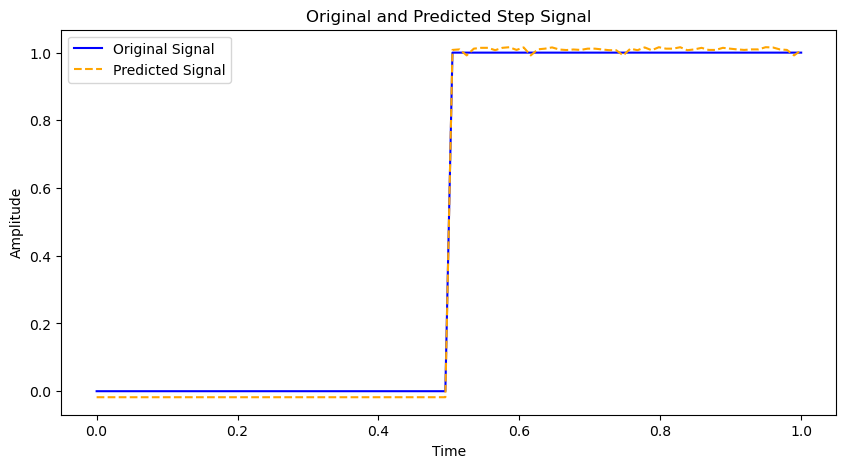

In [ ]:
def generate_spikes_step(num_samples):
    t = np.linspace(0, 1, num_samples)
    signal = np.where(t > 0.5, 1, 0)  # Step function
    spikes = np.random.poisson(signal * 10)  # Poisson spiking
    return spikes, t, signal

def bin_spikes(spikes, times, Q):
    max_t = np.max(times)
    bin_indices = np.floor(Q * times / (max_t + 1e-6)).astype(int)
    bin_indices = np.clip(bin_indices, 0, Q - 1)

    a = np.zeros(Q)
    tau = np.zeros(Q)

    for i in range(Q):
        bin_times = times[bin_indices == i]
        bin_amps = spikes[bin_indices == i]
        if len(bin_amps) > 0:
            a[i] = np.mean(bin_amps)
            tau[i] = np.mean(bin_times)

    a = np.pi * a / (np.max(a) + 1e-6)
    tau = 2 * np.pi * tau / (np.max(tau) + 1e-6)
    return a, tau

def quantum_encode(amplitudes, times):
    qc = QuantumCircuit(NUM_QUBITS)
    for j in range(NUM_QUBITS):
        amp = amplitudes[j] if j < len(amplitudes) else 0
        phi = times[j] if j < len(times) else 0
        qc.u(amp, phi, -phi, j)
    return qc

def apply_vqc(qc, theta):
    for j in range(NUM_QUBITS):
        qc.ry(theta[j], j)
        qc.rz(theta[j + NUM_QUBITS], j)
    return qc

def encode_sample(spikes, t, theta=None):
    Q = NUM_QUBITS
    a, tau = bin_spikes(spikes, t, Q)
    qc = quantum_encode(a, tau)
    if theta is None:
        theta = np.random.uniform(0, 2 * np.pi, 2 * Q)
    qc = apply_vqc(qc, theta)
    qc.measure_all()
    backend = Aer.get_backend("aer_simulator")
    result = execute(qc, backend, shots=SHOTS).result()
    counts = result.get_counts()
    vec = np.array([counts.get(bin(i)[2:].zfill(Q), 0) for i in range(2 ** Q)])
    return vec / np.sum(vec)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def process_and_plot_step():
    num_samples = 100
    spikes, t, signal = generate_spikes_step(num_samples)

    features = []
    for i in range(num_samples):
        features.append(encode_sample(spikes, t))

    features = np.array(features)

    # Scale
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    features_scaled = features_scaled.reshape((features.shape[0], 1, -1))

    model = build_lstm_model((1, features.shape[1]))
    model.fit(features_scaled, signal, epochs=300, batch_size=10, verbose=1)

    predicted_signal = model.predict(features_scaled)

    plt.figure(figsize=(10, 5))
    plt.plot(t, signal, label='Original Step Signal', color='blue')
    plt.plot(t, predicted_signal.flatten(), '--', label='Predicted Signal', color='orange')
    plt.title('Quantum-LSTM Prediction of Step Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    process_and_plot_step()


Plotting the Spikes

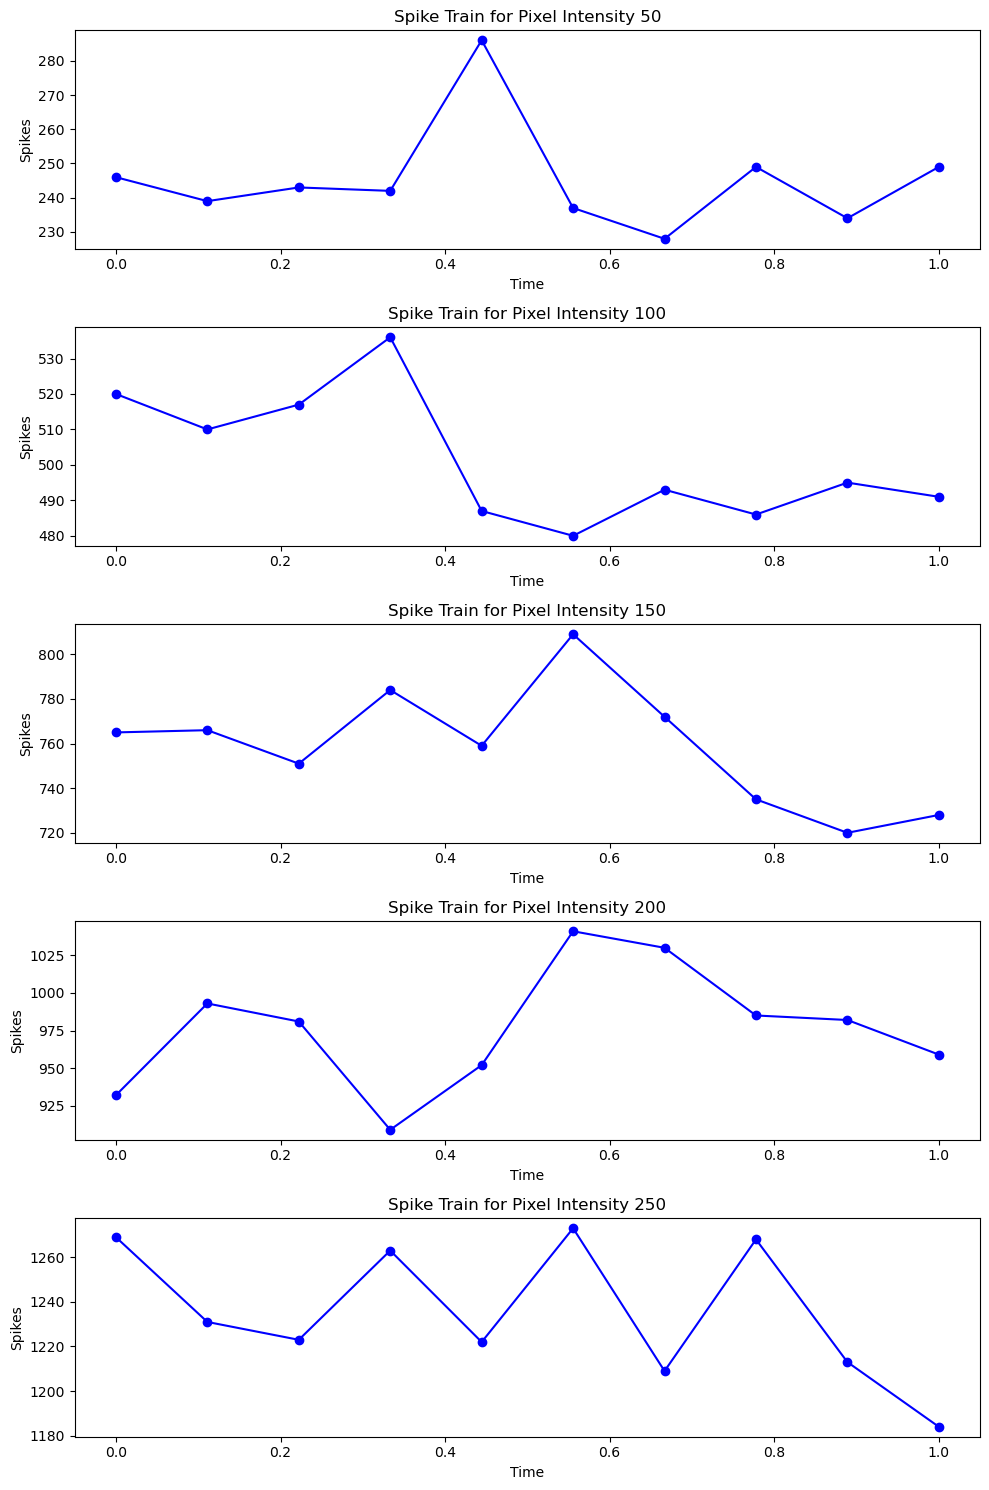

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spikes(image, rate=5, duration=10):
    time_steps = np.linspace(0, 1, duration)
    spikes = np.zeros((image.shape[0], image.shape[1], duration))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            lam = image[i, j] * rate
            spikes[i, j, :] = np.random.poisson(lam=lam, size=duration)
    
    return spikes, time_steps


example_image = np.array([[50, 100, 150, 200, 250],
                          [50, 100, 150, 200, 250],
                          [50, 100, 150, 200, 250],
                          [50, 100, 150, 200, 250],
                          [50, 100, 150, 200, 250]])

spikes, time_steps = generate_spikes(example_image, rate=5, duration=10)


fig, axs = plt.subplots(5, 1, figsize=(10, 15))
pixel_intensities = [50, 100, 150, 200, 250]
for i, intensity in enumerate(pixel_intensities):
    pixel_spikes = spikes[0, i, :]
    axs[i].plot(time_steps, pixel_spikes, 'bo-')
    axs[i].set_title(f"Spike Train for Pixel Intensity {intensity}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Spikes")

plt.tight_layout()
plt.show()


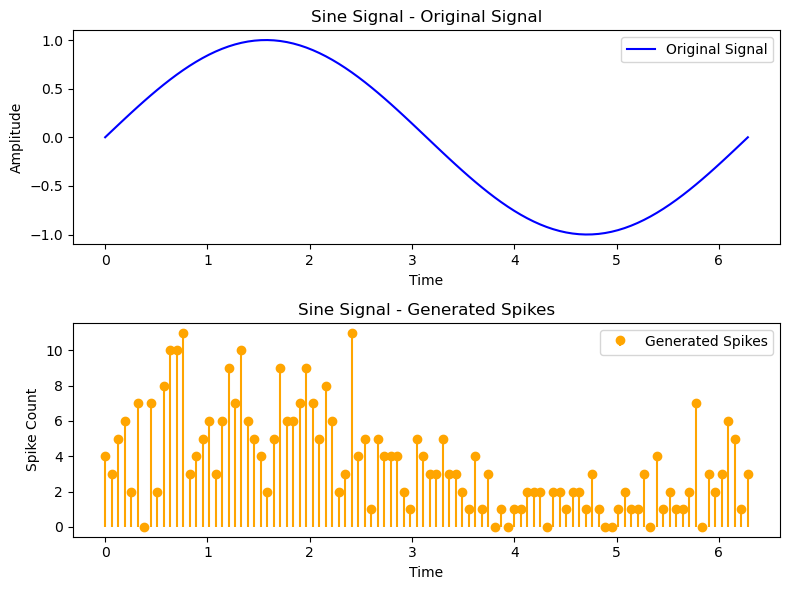

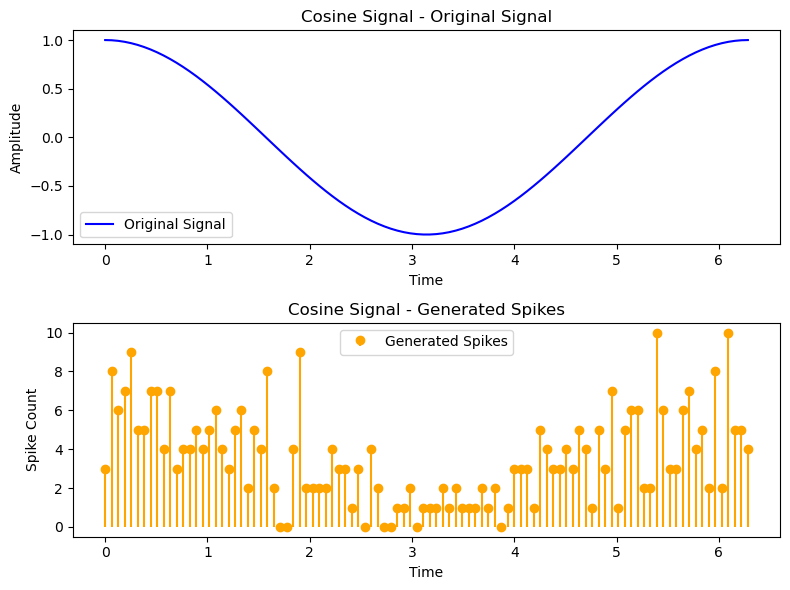

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import ParameterVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

def generate_poisson_spikes(signal_function, num_samples):
    t = np.linspace(0, 2 * np.pi, num_samples)
    signal = signal_function(t)
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) * 5 + 1
    spikes = np.random.poisson(normalized_signal)
    return spikes, t, signal

def process_and_plot(signal_function, title):
    num_samples = 100
    spikes, t, signal = generate_poisson_spikes(signal_function, num_samples)
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal, label='Original Signal', color='blue')
    plt.title(f'{title} - Original Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.stem(t, spikes, linefmt='orange', markerfmt='o', basefmt=" ", label='Generated Spikes')
    plt.title(f'{title} - Generated Spikes')
    plt.xlabel('Time')
    plt.ylabel('Spike Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    process_and_plot(np.sin, 'Sine Signal')
    process_and_plot(np.cos, 'Cosine Signal')

if __name__ == "__main__":
    main()
